# Patent Analysis in Python
### Sample using a training dataset directed at BlockChain patents and predicting relevance in the IBM portofolio
David Andrews
Legal Analytics

This sample connects to Google BigQuery to retrieve patent data.  You need to do some setup in Google's cloud dev platform if you are not already using Google BigQuery.  You can reference one of the many great tutorials on setting up Google BigQuery for the first time to get the libraries installed, credentials cached, and project ID setup.

#### Caveat
This sample uses a very dumb training set.  The 'positive' samples, or samples labeled as being related to Block Chain, were gathered by doing a simple keyword search on Google Patents.  The results were not reviewed by hand and there was no effort to be inclusive.  As a result, the final results are interesting, but not demonstrative of what a fully-trained ML model can do when predicting results.  The 'negative' samples were created by doing a random search for patents, which means they are probably not blockchain related.  Immediately better results could be obtained by providing negative samples that weed out things like financial transactions patents that don't use block chain or similar technology. If you improve the training set and I would appreciate the opportunity to improve these results by including your updated training data.  You can email me at david@analytics.legal and I can re-publish the training sets.

In [1]:
%matplotlib inline
#import lots of stuff
from google.cloud import bigquery
import pandas as pd
import matplotlib.pylab as plt
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from IPython.display import display, HTML


# Load Training Data

In [2]:
#load in the samples of patents we want to find
#these files are just flat lists of patent numbers.  Positives are examples of block chain patents and negatives 
#are random non-blockchain patents.  Stored on public google sheets share.
negative_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTwNjPYeJV6l0lOTjMnI65rE4i_Prtc4Gnku3HupqBzuZ5v9wzhYWAA26AivTkFPw_AbwGuiuqoj_lq/pub?output=csv"
positive_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSD-tiMAUTosTzEz9jiqK0JMhFLr3s_Jeb7J5Ry39NoIaEHE-Iqr1M7etvDJBTZA0ilgmUjb6KU-TCs/pub?output=csv"
df_positive_samples = pd.read_csv(positive_url)
#load samples of patents that are counter-examples
df_negative_samples = pd.read_csv(negative_url)

#Create Label column to hold the labels
#label blockchain patents 1
df_positive_samples['Label'] = 1
#label non-blockahin patents 0
df_negative_samples['Label'] = 0

#combine labeled data into a training set
df_training_set = pd.concat([df_positive_samples, df_negative_samples], ignore_index=True)

#change the format of the publication number from US1234567B2 to US-1234567-B2 to match the format in the database
df_training_set['Publication_Number'] = df_training_set['Publication_Number'].str.replace(r"(\D*)(\d*)(\D\d?)", "\\1-\\2-\\3")
#input data has some funky pub numbers for applications with an extra 0 after the year portion of the pub number.
#need to strip it so it matches the format in Google BigQuery
df_training_set['Publication_Number'] = df_training_set['Publication_Number'].str.replace(r"(\D*-)(\d{4})0(\d{6})(-A1)",
                                                                                         "\\1\\2\\3\\4")

#unpacking the above REGEXP a little:
# (\D*) = grab all the non-digits at the front e.g. US
# (\d*) = grab all the digits, e.g. 1234567
# (\D\d?) = grab a trailing non-digit optionally followed by a digit e.g. A1 or B2 or A 


df_training_set.drop_duplicates(['Publication_Number'], inplace=True)
#show the training set to see what it looks like.  Make sure it imported correctly.
display(df_training_set)


,Publication_Number,Label
0,US-2015310424-A1,1
1,US-2015120567-A1,1
2,US-2015170112-A1,1
3,US-2015379510-A1,1
4,US-2015287026-A1,1
5,US-2015356555-A1,1
6,US-2015332256-A1,1
7,US-2015371224-A1,1
8,US-2015332283-A1,1
9,US-2015206106-A1,1


Note there are some non-US patents in the Negatives training example.  Our SQL join below will weed those out, so you may notice that the row count decreases from this query to the next.

# Connect to  Google BigQuery and upload patent numbers & labels

In [3]:
#load the dataset to Google BigQuery so we can join against the public patents data

#If you don't want to try to get GBQ working, you can download the results of this step here:
#combined_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSfXq_QpXjL3eskKnbezF33GgcBM7O1KB-TAPrfcZk1cYXdQWQWU5X_oAICJr5ipXearXbJ19_Rp4PY/pub?output=csv"
#df_training_set_finished = pd.read_csv("combined_url")
#then skip to Prepare Machine Learning Pipeline below


# Variables to be used to access GBQ, replace with your project id, and optionally change the table and
# and dataset name.
PROJECT_ID = 'patenttest-182300' #change this to your project ID
DEST_DATASET = 'my_new_dataset'
samples_table = 'training_patents'

# Create a python client we can use for executing table creation queries
client = bigquery.Client(project=PROJECT_ID)
# Create an HTTP client for additional functionality.
credentials = GoogleCredentials.get_application_default()
http_client = discovery.build('bigquery', 'v2', credentials=credentials)

#attach to the dataset
dataset = client.dataset(DEST_DATASET)

#create the table by having Pandas push up the dataframe as a table
full_table_path = '{}.{}'.format(DEST_DATASET, samples_table)
df_training_set.to_gbq(destination_table=full_table_path,
          project_id=PROJECT_ID,
          if_exists='replace')





Streaming Insert is 100.0% Complete




# Query BigQuery to get training text

In [4]:
#create our query string.  The query joins the BigQuery patent data using our training set
# publication number.  Because we formatted in Python to match the BigQuery format, we can just use traing equality
# in the "on" clause of the join.
# The concat combines the data fields we are interested in.  For our training data, we are going to use
# the title, abstract, claims, and CPC codes combined into one text block to feed into the machine learning code.

query = """
select pubs.publication_number, Label,
  CONCAT(
    IFNULL(
     (SELECT text from UNNEST(pubs.title_localized)), " "), " ",
    IFNULL(
     (SELECT text from UNNEST(pubs.abstract_localized)), " "), " ",
    IFNULL(  
     (SELECT text from UNNEST(pubs.claims_localized)), " "), " ",
    IFNULL(
     ARRAY_TO_STRING( ARRAY(SELECT code from UNNEST(pubs.cpc)), " "), " " ), " ",
    IFNULL(
     ARRAY_TO_STRING( ARRAY(SELECT REGEXP_REPLACE( code, "/.*", "") from UNNEST(pubs.cpc)), " "), " ")) as text
from
  `patents-public-data.patents.publications` as pubs, UNNEST(title_localized) as title
  JOIN `""" + full_table_path + """` as input
  on pubs.publication_number = input.Publication_Number  
where (SELECT language from UNNEST(pubs.title_localized) LIMIT 1) = 'en' and
(SELECT language from UNNEST(pubs.abstract_localized) LIMIT 1) = 'en' and
(SELECT language from UNNEST(pubs.claims_localized) LIMIT 1) = 'en'
"""
df_training_set_finished = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard')
#check to make sure we got back a dataset that looks right.
print("Shape:", df_training_set_finished.shape)

Requesting query... ok.
Job ID: job_Ic0ZpX_SFT1RjExOrNCJOgc8D63N
Query running...
Query done.
Processed: 155.0 GB
Standard price: $0.76 USD

Retrieving results...
Got 1101 rows.

Total time taken 6.62 s.
Finished at 2018-01-15 16:18:33.
Shape: (1101, 3)


# Prepare Machine Learning Pipeline

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix


In [6]:
#now that the data is prepared, get ready to do the ML training.
features, labels = shuffle( df_training_set_finished['text'].values, df_training_set_finished['Label'])

#Grid sweep parameters to use the SGDClassifier
#there are lots of options on algorithm and parameters to try.  These are some that have worked the best
#for me in the past on similar data.
parameters = {
    'loss': ['log'],
    'penalty': ['none', 'l2', 'l1', 'elasticnet'],
    'n_iter':[3, 8, 12],
    'alpha': [0.001, 0.01, 0.1 ],
    'learning_rate': ['constant','optimal','invscaling'],
    'eta0':[.5,1],
    'class_weight': ['balanced', None]
}

#Grid search will find the best combination of parameters to use in our ML model
grid_search = GridSearchCV(SGDClassifier(), parameters )

#Stick a CountVectorizer, which will convert the text into word counts in the pipeline
#Next, use a TF-IDF transformer to convert the word counts to TFIDF
#Last, do the grid search.
#store this all in a pipeline so we can do it over and over.
text_clf = Pipeline( [('vect', CountVectorizer(stop_words='english')),
     ('tfidf',TfidfTransformer()),
     ('clf',grid_search)])

# Search the grid for the best trained model

In [7]:
#Fit the data
print("Grid Searching")
text_clf.fit( features, labels)
print("Best Score", grid_search.best_score_)
print( "Best parameters set:" )
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print ("\t%s: %r" % (param_name, best_parameters[param_name]))
    


Grid Searching
Best Score 0.932788374205
Best parameters set:
	alpha: 0.001
	class_weight: None
	eta0: 1
	learning_rate: 'constant'
	loss: 'log'
	n_iter: 12
	penalty: 'none'


# Save the best model and do cross validation

In [8]:
#grab the best estimator from the grid search
estimator = grid_search.best_estimator_
#create a reuseable pipepline to do the predictions
final_pipeline = Pipeline( [('vect', CountVectorizer(stop_words='english')),
     ('tfidf',TfidfTransformer()),
     ('estimator', estimator)])

# split data 65%-35% into training set and test set
features_train, features_test, labels_train, labels_test = train_test_split(df_training_set_finished['text'].values,
                                                                            df_training_set_finished['Label'].values, test_size=0.35)
final_pipeline.fit( features_train, labels_train )

accuracy = final_pipeline.score(features_test, labels_test)
print("Accuracy: ", accuracy)

#uncomment here to do a cross val score instead of the test/train split above
#score = cross_val_score( final_pipeline, features, labels)
#print("cross val score:", score)


Accuracy:  0.906735751295


Confusion Matrix:
			  Pred True 	 Pred False
BlockChain True: 	 254 		 8
BlockChain False: 	 28 		 96
False Negatives: 8
False Positives: 28


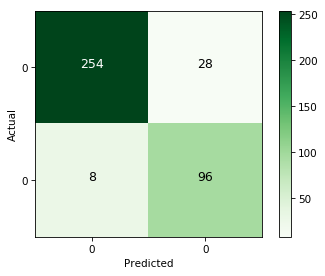

In [9]:
#plot confusion matrix
labels_predicted = final_pipeline.predict(features_test)
cm = confusion_matrix(labels_test, labels_predicted)

#print in text format
print("Confusion Matrix:\n\t\t\t", " Pred True \t Pred False")
print
print("BlockChain True:","\t", cm[0][0], "\t\t", cm[0][1])
print("BlockChain False:","\t", cm[1][0], "\t\t", cm[1][1])
print("False Negatives:", cm[0][1])
print("False Positives:", cm[1][0])

#now plot confusion matrix with matplotlib to get all fancy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(6, 4), dpi=75)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Greens)
plt.colorbar()
tick_marks = [0,1]
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax = fig.add_subplot(1,1,1)
ax.text(0, 0, str(cm[0][0]), color='white', fontsize=12, horizontalalignment='center')
ax.text(1, 0, str(cm[1][0]), color='black', fontsize=12, horizontalalignment='center')
ax.text(0, 1, str(cm[0][1]), color='black', fontsize=12, horizontalalignment='center')
ax.text(1, 1, str(cm[1][1]), color='black', fontsize=12, horizontalalignment='center')

plt.show()




# Pull target porfolio
Note: this is a very unsophisticated way to pull the target portfolio.  The best way, in my experience, is to use a third party database that includes all reassignment data.  You can upload patent numbers to GBQ and do a join much as we did on the training data above.  The technique below, however, isn't bad for large portfolios like IBM, Google, and Microsoft, to get an idea before you spend a lot of time making sure you have the correct portfolio to search.  Companies like Intellectual Ventures, which uses many different holding companies, can be notoriously hard to search.

In [10]:
#get target portofolio
#pull patent applications where the harmonized assignee is Amazon on the face of the patent (might not be current assignee)
#The query creates the same text as above, but this time we will use it for prediction instead of training.
#this might take a while.  Amazon should have about 8,000 rows, so it will fetch and process quickly.
#the query pares the data down by having only patents published after 2000.  If you want a larger dataset, try uncommenting
#one of the other assignees bellow.

#if you don't want to use Google BigQuery, you can load the results from here:
#df_target = pd.read_csv()

#assignee = "IBM%"
#assignee = "GOOGLE%"
#assignee = "MICROSOFT%"
assignee = "AMAZON TECH%"

query = """
select pubs.publication_number, --pubs.assignee_harmonized,
      (SELECT text from UNNEST(pubs.title_localized)) as title,
        CONCAT(IFNULL(
         (SELECT text from UNNEST(pubs.title_localized)), " "), " ",
        IFNULL(
         (SELECT text from UNNEST(pubs.abstract_localized)), " "), " ",
        IFNULL(  
         (SELECT text from UNNEST(pubs.claims_localized)), " "), " ",
        IFNULL(
         ARRAY_TO_STRING( ARRAY(SELECT code from UNNEST(pubs.cpc)), " "), " " ), " ",
        IFNULL(
         ARRAY_TO_STRING( ARRAY(SELECT REGEXP_REPLACE( code, "/.*", "") from UNNEST(pubs.cpc)), " "), " ")) as text
from
  `patents-public-data.patents.publications` as pubs, UNNEST(title_localized) as title
where 
country_code = 'US' and  --US only
application_kind = 'A' and --patents only
publication_date > 20000000 and  --The patents table uses a very awkward date formulation.  This queries for patents published after Jan 1, 2000.
EXISTS( SELECT 1 name from UNNEST(assignee_harmonized) where name LIKE '"""+ assignee + """')"""

df_target = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard')

print(df_target.shape)


Requesting query... ok.
Job ID: job_D9gakZHCX35BshdCyHhI-Zu_JKcA
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 3; 34% done. Elapsed 7.72 s.
  Got page: 4; 45% done. Elapsed 10.42 s.
  Got page: 5; 56% done. Elapsed 13.32 s.
  Got page: 6; 67% done. Elapsed 16.02 s.
  Got page: 7; 78% done. Elapsed 18.23 s.
  Got page: 8; 89% done. Elapsed 20.65 s.
  Got page: 9; 100% done. Elapsed 23.1 s.
Got 8216 rows.

Total time taken 23.19 s.
Finished at 2018-01-15 16:20:04.
(8216, 3)


In [11]:
# Use the pipeline and run the predictions.
#using predict_proba gives us the probabilty rather than the label. This helps in sorting later.
#this might also take a while
predictions = final_pipeline.predict_proba(df_target.text.values)

#add the predictions to the dataframe
# The predictions outcome for our model is tuple of the likelihood of being in category 0 or category 1.
#  The list comprehension below splits off just the probability of the row being in Category 1.
df_target['BlockChainPredictions'] = [j for i,j in predictions]



In [12]:
#lets look at the top 20 patents IBM owns that might be relevant to BlockChain:
df_display = df_target.nlargest(20, 'BlockChainPredictions').sort_values('BlockChainPredictions', ascending=False)
#Why do nlargest and then sort, as opposed to doing sort and slicing?  Because n-largest only requires one
#pass through the data, then sorting 20 items is trivial.  Sorting all ~200k patents is wasteful when we only want the top 20.

#make columns wrap instead of truncate:
pd.set_option('display.max_colwidth', -1)
#drop the text column on display so it doesn't clutter everything, then display
display(df_display.drop("text", axis=1))


,publication_number,title,BlockChainPredictions
518,US-9311500-B2,Data security using request-supplied keys,0.970489
5980,US-2016217290-A1,Data security using request-supplied keys,0.968580
3798,US-8600886-B2,Managing transaction accounts,0.959393
5974,US-2012136710-A1,Digital Coupon System,0.957294
7828,US-2012136707-A1,Digital Coupon System,0.956874
2393,US-2012136712-A1,Digital Coupon System,0.952514
4759,US-2013238504-A1,Performing automatically authorized programmatic transactions,0.947606
5570,US-2015089244-A1,Data security using request-supplied keys,0.945723
1477,US-2016191241-A1,Distributed public key revocation,0.945159
1316,US-2017195283-A1,Allocating identifiers with minimal fragmentation,0.937665


# Conclusion
The results are interesting.  If you are looking at the Amazon results, you can see there are some patent titles that look highly related in the top 20, and some that look way off.  From here, the magic is improving your training data by adding positive and negative examples.  Additionally, "Block Chain" may be too broad of a topic.  Do you want applications of block chain, or the underlying mechanism that drives block chain?  Are you looking for the component parts of Block Chain like cryptographic functions, or are you only interested in patents that are refinements to the overall Block Chain system?

This is a bit of a toy example to let people get started actually doing data science experiments on real patent data.  This tutorial is aimed at the relative beginner to machine learning.

I hope you have learned something by reading this walk through.  Find me on LinkedIn at https://www.linkedin.com/in/davidandrewsjd/.  

David Andrews
Founder
Legal Analytics